In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'USD=X'
numbers_in_currency = 'USD'
share_name = 'SMG'

# 1.1 Calculate Share numbers from total distributed dividend (CFS) and dividend amount

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares
0,2014-03-31,1081,-647,434,126,153,747,546,1938,333,...,3071,343,0,279,1018,1145,2396,-434,-10,62.7
1,2014-06-30,1116,-693,423,121,147,512,388,1411,333,...,2506,279,0,201,908,629,1751,649,-16,62.7
2,2014-09-30,191,-192,-1,-35,89,224,385,935,351,...,2058,193,0,92,545,692,1505,207,-19,62.7
3,2014-12-31,170,-163,7,-75,130,185,683,1126,364,...,2265,220,0,37,422,1133,1818,-267,-15,62.2
4,2015-03-31,1072,-647,425,139,55,682,596,1864,372,...,3010,300,0,318,985,1211,2454,-382,-14,62.2


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
35,2022-12-31,2023-02-11,56.0,527,-421,106,-65,26,311,1526,...,576,4534,367,0,217,932,3173,4475,-432,-30
36,2023-04-01,2023-04-22,56.0,1532,-1,531,109,25,1036,1128,...,566,4988,416,0,435,1373,3122,4851,-135,-22
37,2023-07-01,2023-07-22,56.0,1119,-880,239,44,27,718,885,...,560,4454,366,0,451,1329,2613,4320,563,-22
38,2023-09-30,2023-10-21,56.0,375,-408,-33,-468,32,304,880,...,437,3414,271,0,52,774,2542,3681,535,-19
39,2023-12-31,2024-02-11,56.0,410,-354,56,-81,10,288,1170,...,433,3716,333,0,55,764,2954,4102,-343,-38


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
if currency_pair != 'USD=X':
    data['usd_nat_currency'] = utils.daily_price(
        ticker=currency_pair,
        end=data['date'],
        days_earlier=90
        )
else:
    data['usd_nat_currency'] = [1 for x in range(len(data))]

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
35,2022-12-31,2023-02-11,56.0,527,-421,106,-65,26,311,1526,...,4534,367,0,217,932,3173,4475,-432,-30,1
36,2023-04-01,2023-04-22,56.0,1532,-1,531,109,25,1036,1128,...,4988,416,0,435,1373,3122,4851,-135,-22,1
37,2023-07-01,2023-07-22,56.0,1119,-880,239,44,27,718,885,...,4454,366,0,451,1329,2613,4320,563,-22,1
38,2023-09-30,2023-10-21,56.0,375,-408,-33,-468,32,304,880,...,3414,271,0,52,774,2542,3681,535,-19,1
39,2023-12-31,2024-02-11,56.0,410,-354,56,-81,10,288,1170,...,3716,333,0,55,764,2954,4102,-343,-38,1


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
35,2022-12-31,2023-02-11,56.0,527.0,-421.0,106.0,-65.0,26.0,311.0,1526.0,...,4534.0,367.0,0.0,217.0,932.0,3173.0,4475.0,-432.0,-30.0,1
36,2023-04-01,2023-04-22,56.0,1532.0,-1.0,531.0,109.0,25.0,1036.0,1128.0,...,4988.0,416.0,0.0,435.0,1373.0,3122.0,4851.0,-135.0,-22.0,1
37,2023-07-01,2023-07-22,56.0,1119.0,-880.0,239.0,44.0,27.0,718.0,885.0,...,4454.0,366.0,0.0,451.0,1329.0,2613.0,4320.0,563.0,-22.0,1
38,2023-09-30,2023-10-21,56.0,375.0,-408.0,-33.0,-468.0,32.0,304.0,880.0,...,3414.0,271.0,0.0,52.0,774.0,2542.0,3681.0,535.0,-19.0,1
39,2023-12-31,2024-02-11,56.0,410.0,-354.0,56.0,-81.0,10.0,288.0,1170.0,...,3716.0,333.0,0.0,55.0,764.0,2954.0,4102.0,-343.0,-38.0,1


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

## Calculate performance parameters (current ratio, ROA, ROE, margins, D/E)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2014-04-21,43.501438,2014-03-31,1081.0,8.038278,10.76555,62.7,-1696.0,-27.049442,153.0,...,0.219798,0.780202,5.788487,7.54519,28.261438,4.739927,0.40148,0.116559,0.164116,0.746667
1,2014-04-28,44.012466,2014-03-31,1081.0,8.038278,10.76555,62.7,-1696.0,-27.049442,153.0,...,0.219798,0.780202,5.788487,7.54519,28.261438,4.739927,0.40148,0.116559,0.164116,0.746667
2,2014-05-05,43.904491,2014-03-31,1081.0,8.038278,10.76555,62.7,-1696.0,-27.049442,153.0,...,0.219798,0.780202,5.788487,7.54519,28.261438,4.739927,0.40148,0.116559,0.164116,0.746667
3,2014-05-12,43.494236,2014-03-31,1081.0,8.038278,10.76555,62.7,-1696.0,-27.049442,153.0,...,0.219798,0.780202,5.788487,7.54519,28.261438,4.739927,0.40148,0.116559,0.164116,0.746667
4,2014-05-19,43.213539,2014-03-31,1081.0,8.038278,10.76555,62.7,-1696.0,-27.049442,153.0,...,0.219798,0.780202,5.788487,7.54519,28.261438,4.739927,0.40148,0.116559,0.164116,0.746667


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2014-04-21,43.501438,2014-03-31,1081.0,8.038278,10.76555,62.7,-1696.0,-27.049442,153.0,...,4.739927,0.40148,0.116559,0.164116,0.746667,5.411786,4.040800,0.630791,1.149524,-1.608219
1,2014-04-28,44.012466,2014-03-31,1081.0,8.038278,10.76555,62.7,-1696.0,-27.049442,153.0,...,4.739927,0.40148,0.116559,0.164116,0.746667,5.475360,4.088269,0.638201,1.156934,-1.627112
2,2014-05-05,43.904491,2014-03-31,1081.0,8.038278,10.76555,62.7,-1696.0,-27.049442,153.0,...,4.739927,0.40148,0.116559,0.164116,0.746667,5.461928,4.078239,0.636635,1.155368,-1.623120
3,2014-05-12,43.494236,2014-03-31,1081.0,8.038278,10.76555,62.7,-1696.0,-27.049442,153.0,...,4.739927,0.40148,0.116559,0.164116,0.746667,5.410890,4.040131,0.630687,1.149419,-1.607953
4,2014-05-19,43.213539,2014-03-31,1081.0,8.038278,10.76555,62.7,-1696.0,-27.049442,153.0,...,4.739927,0.40148,0.116559,0.164116,0.746667,5.375970,4.014058,0.626616,1.145349,-1.597576


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

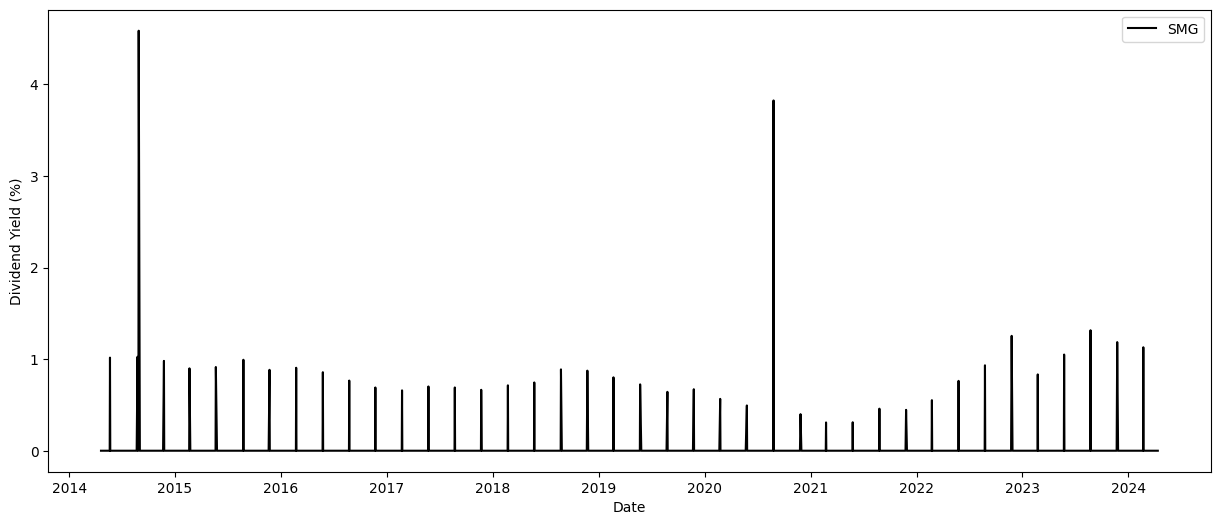

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate   NaN
share_price     NaN
Name: share_price, dtype: float64


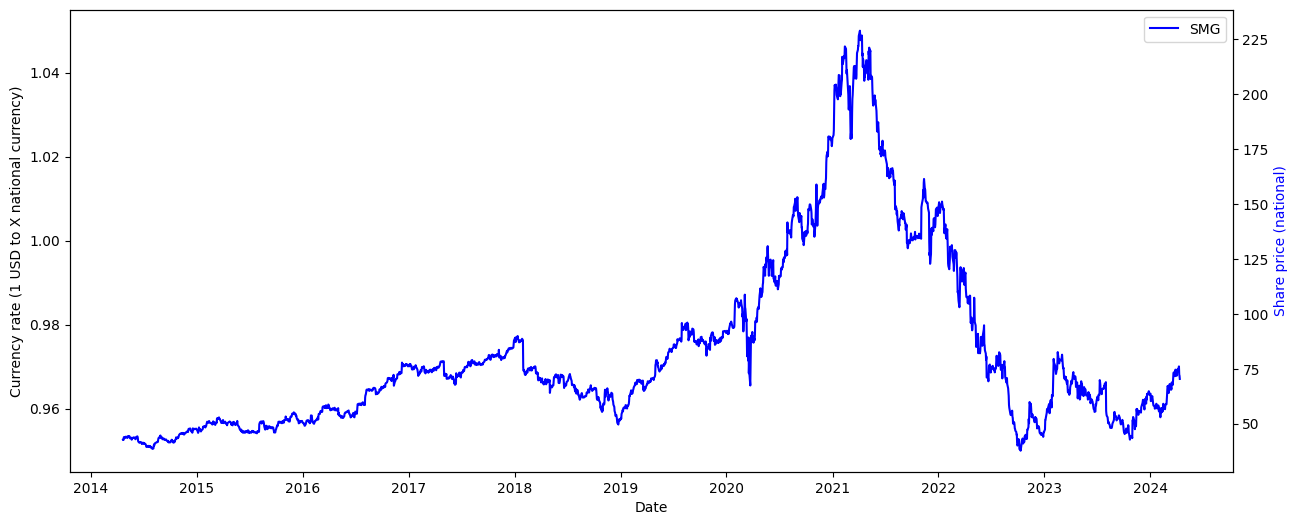

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

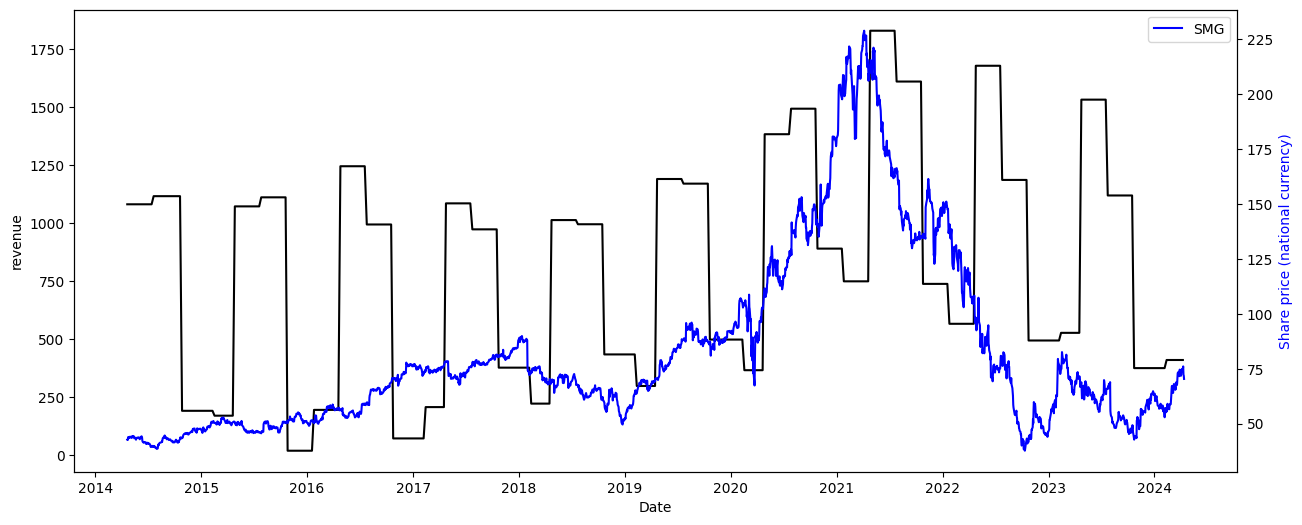

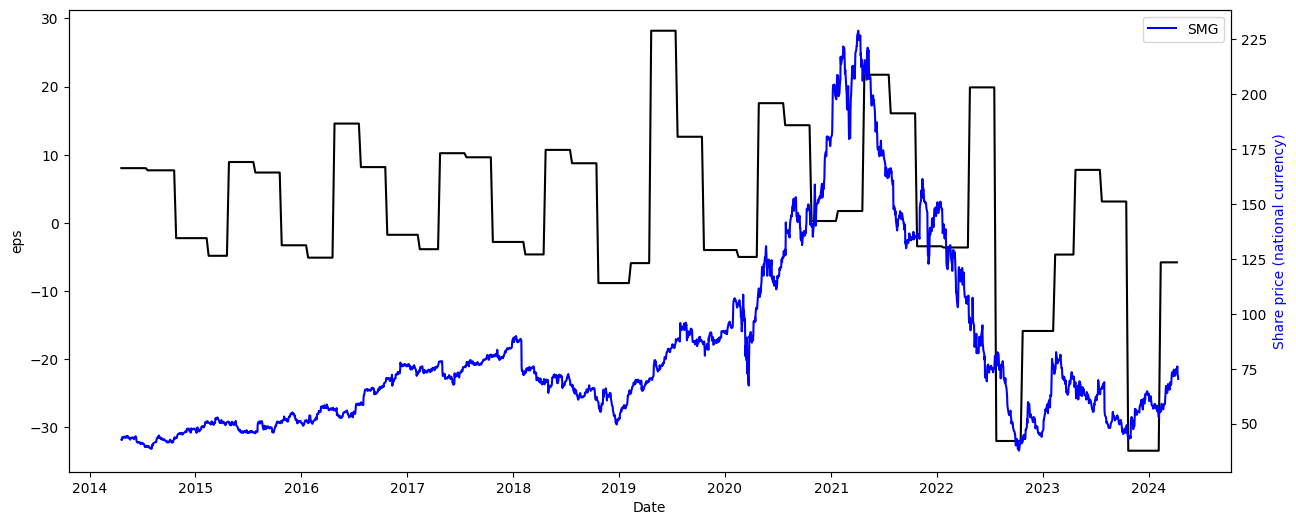

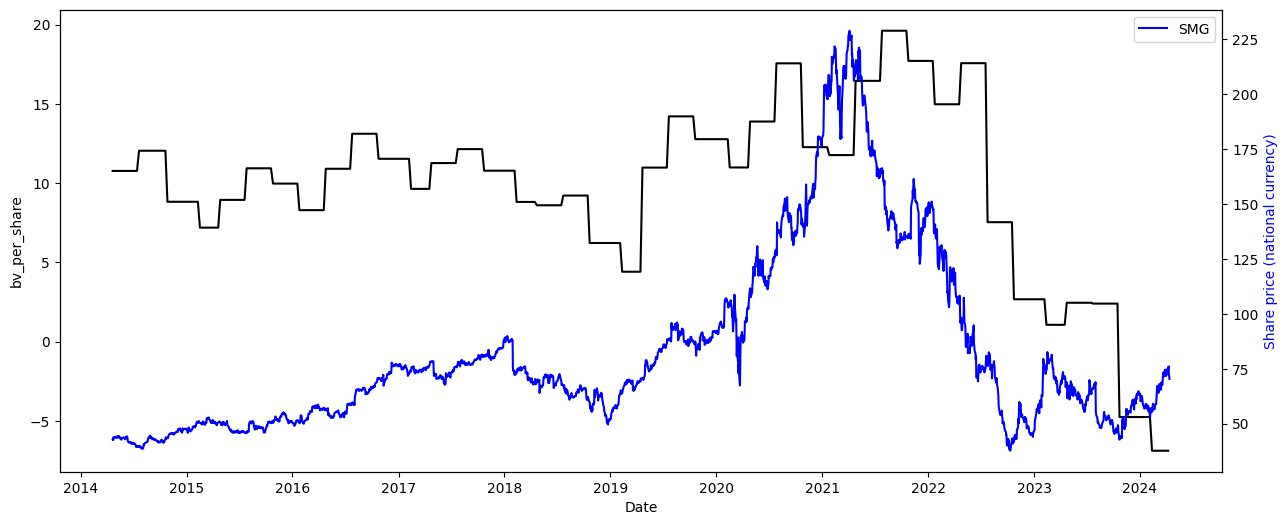

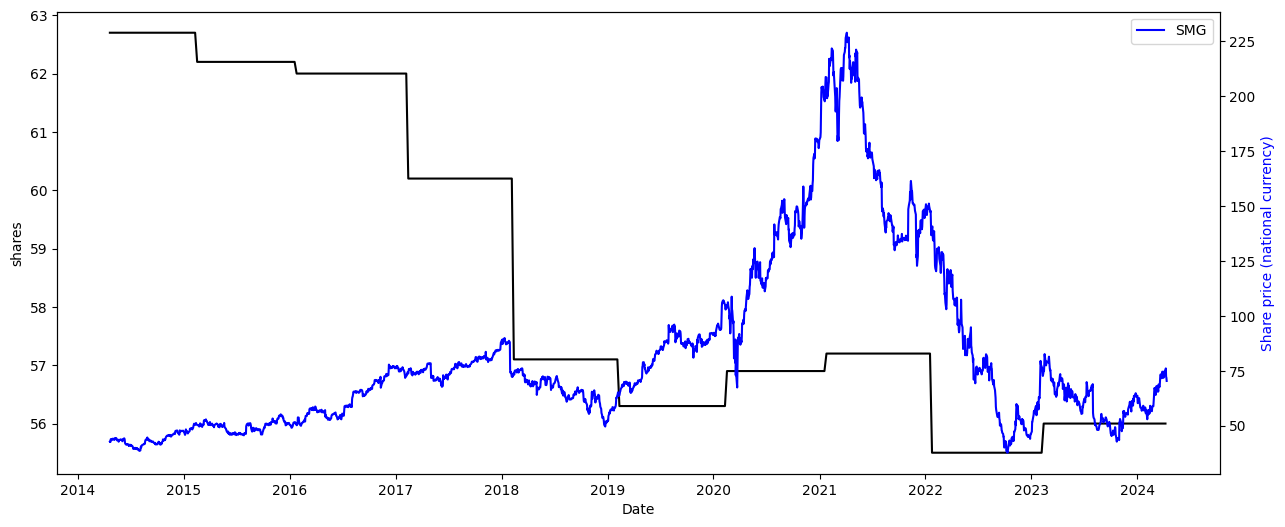

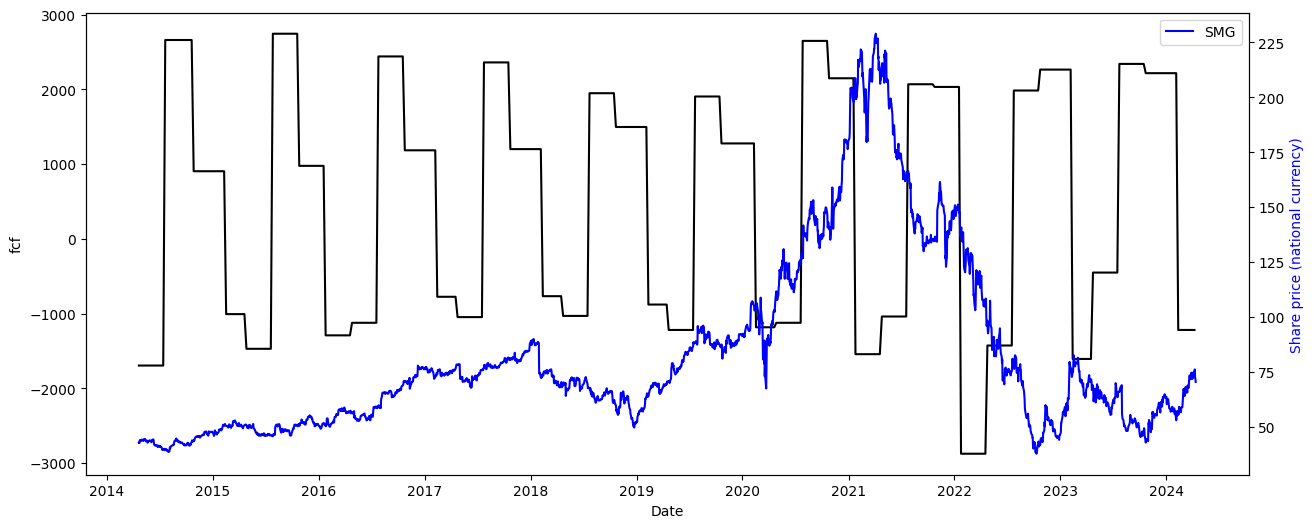

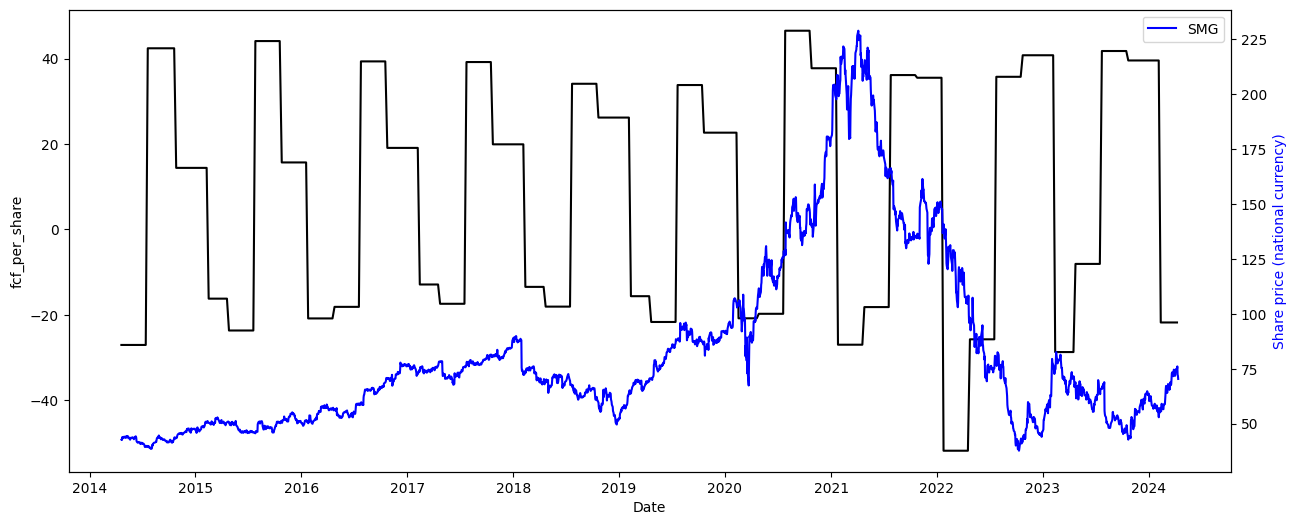

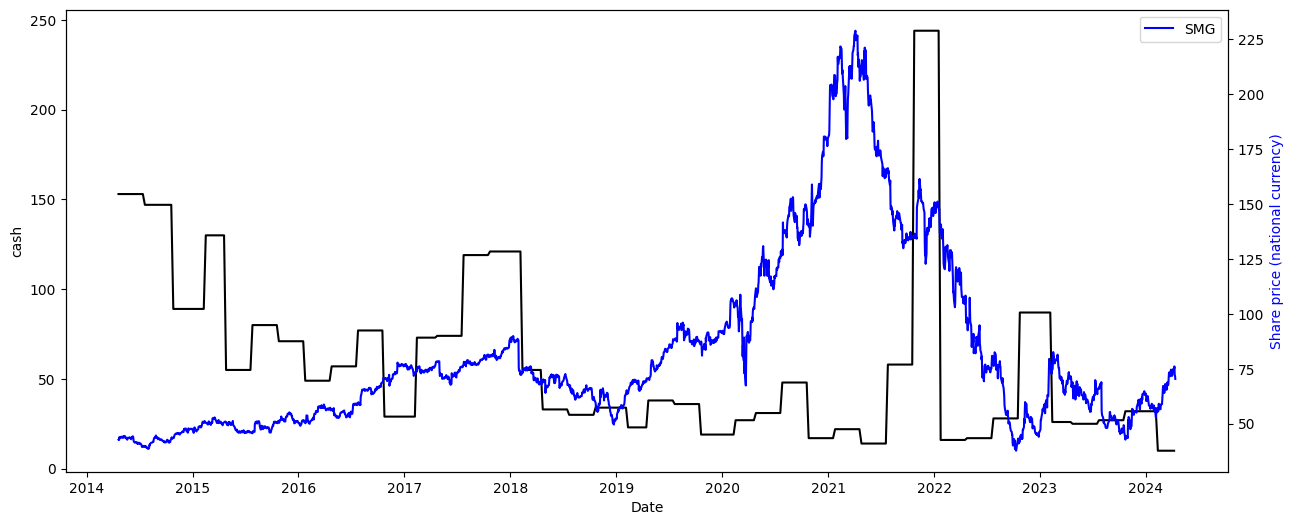

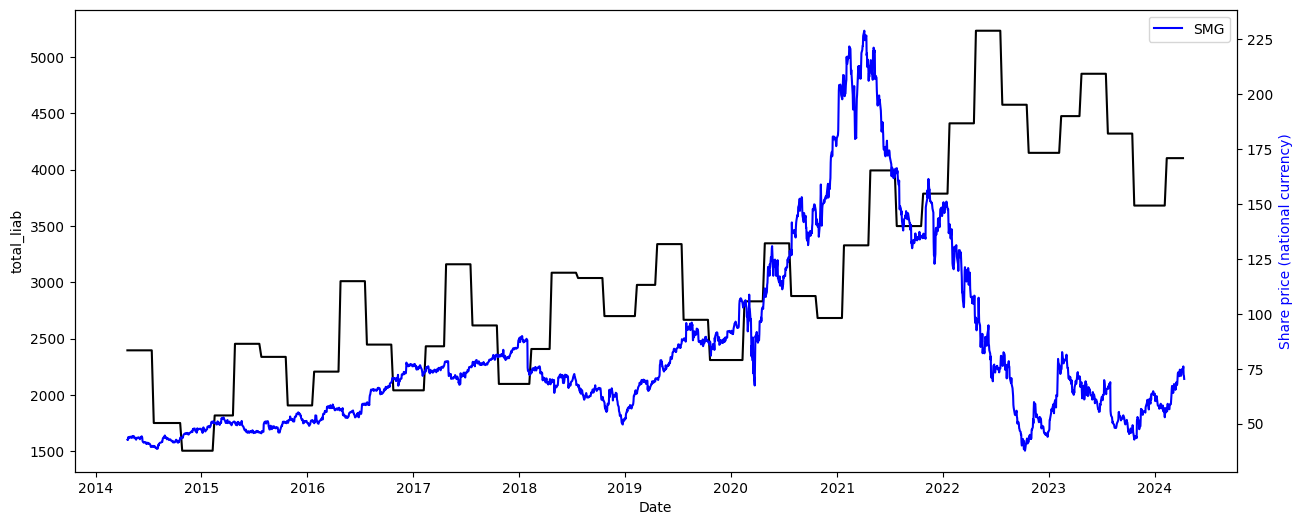

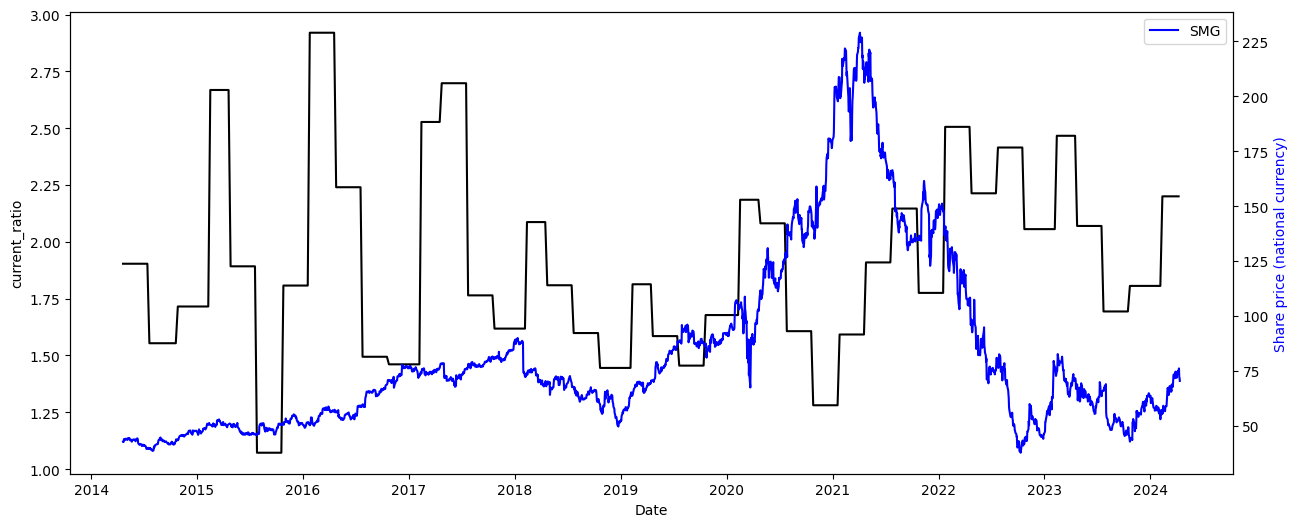

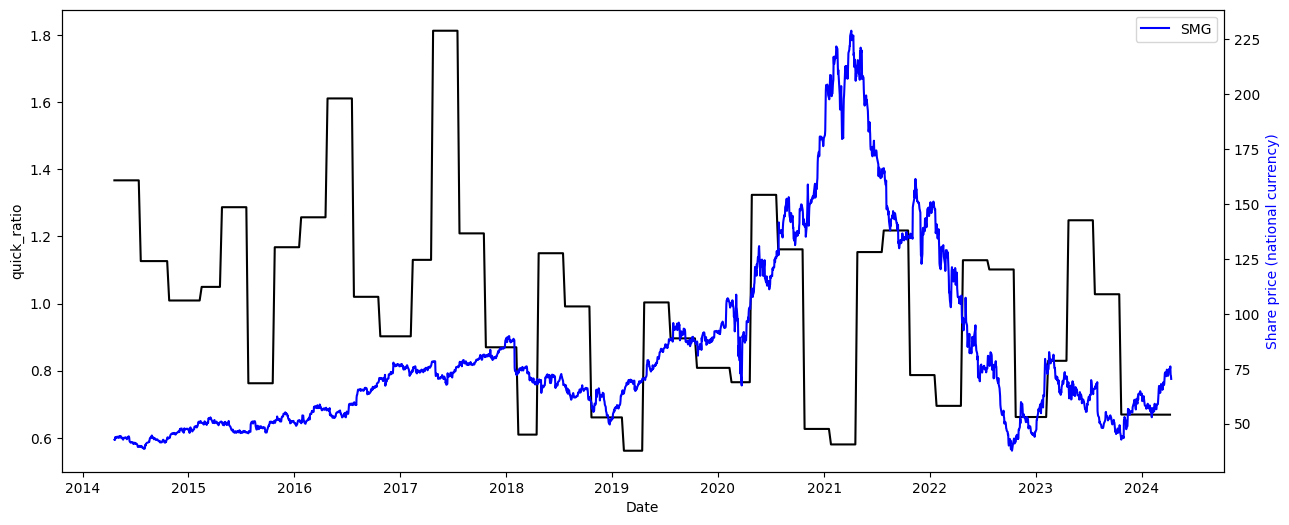

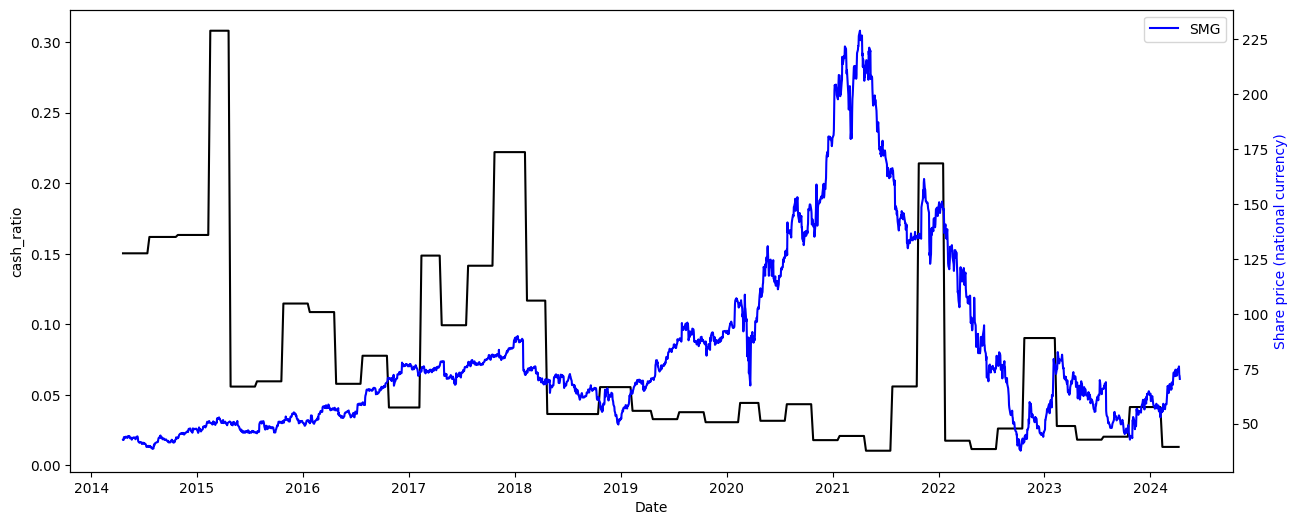

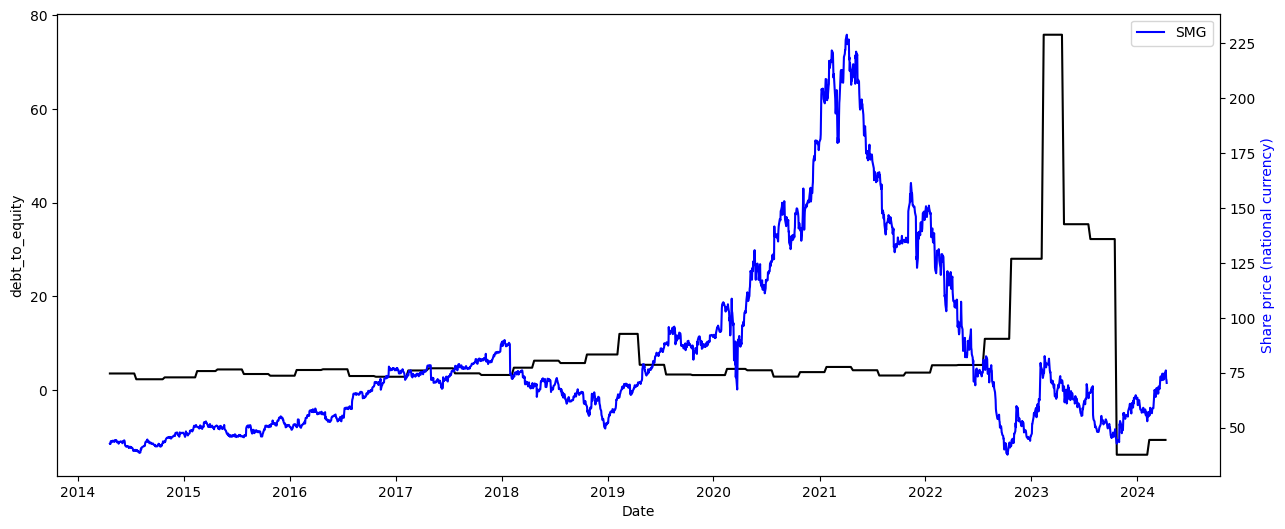

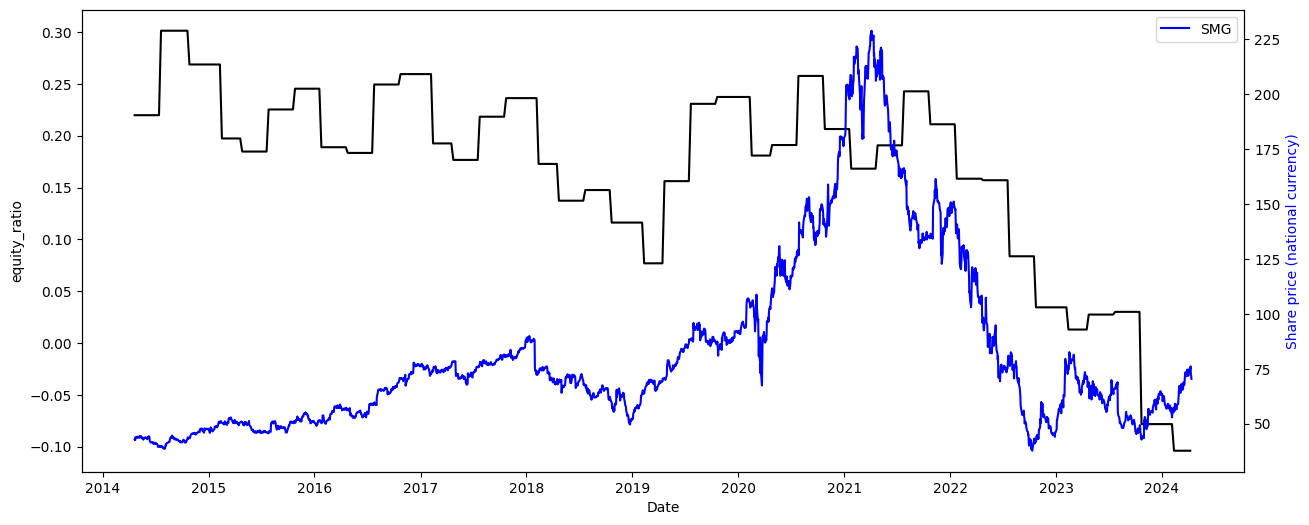

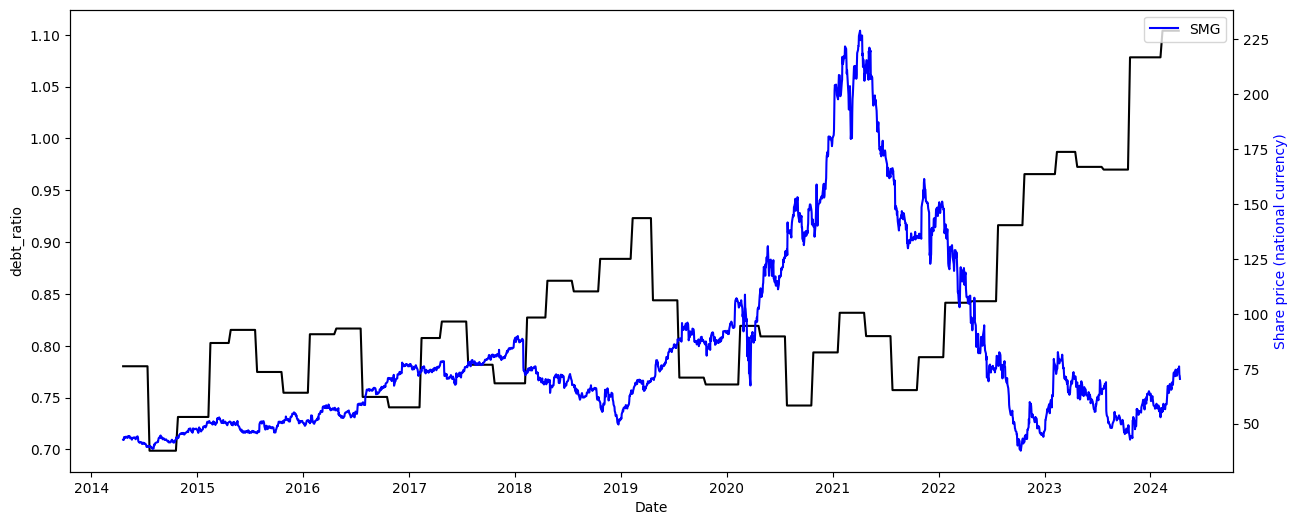

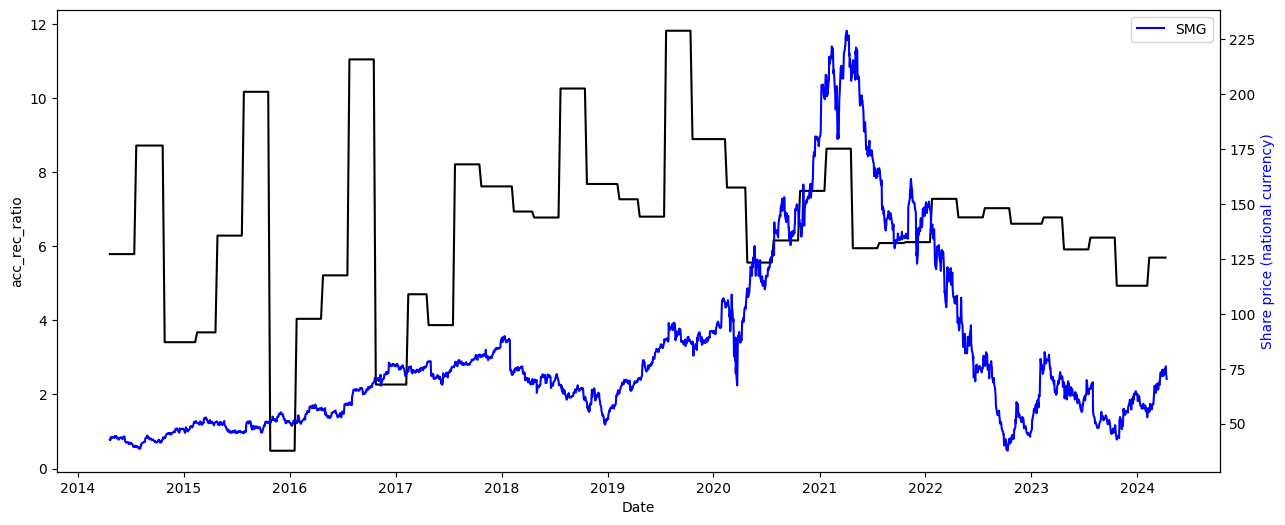

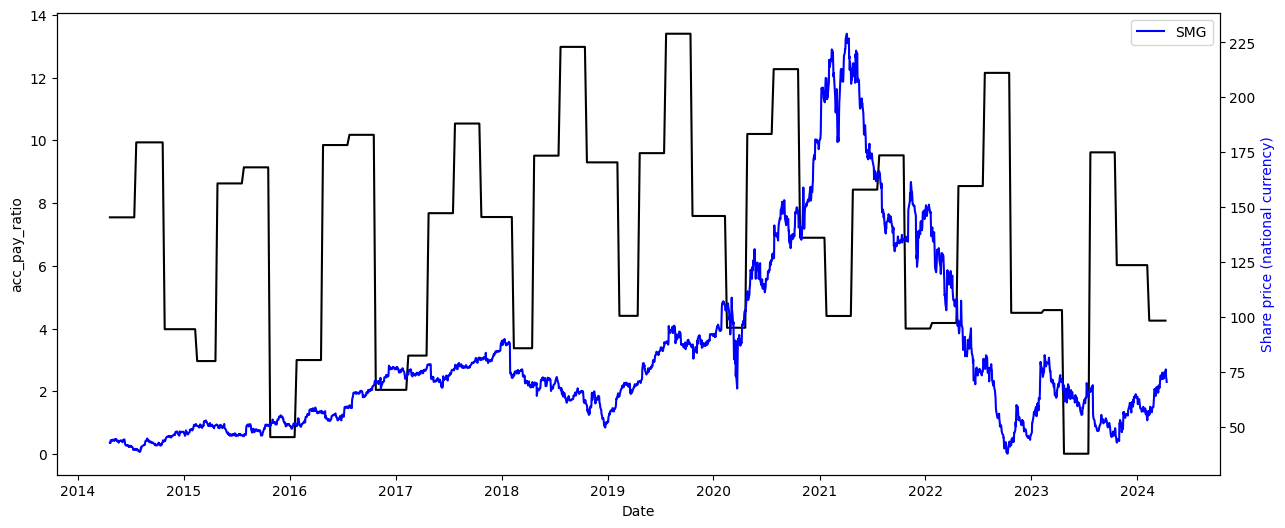

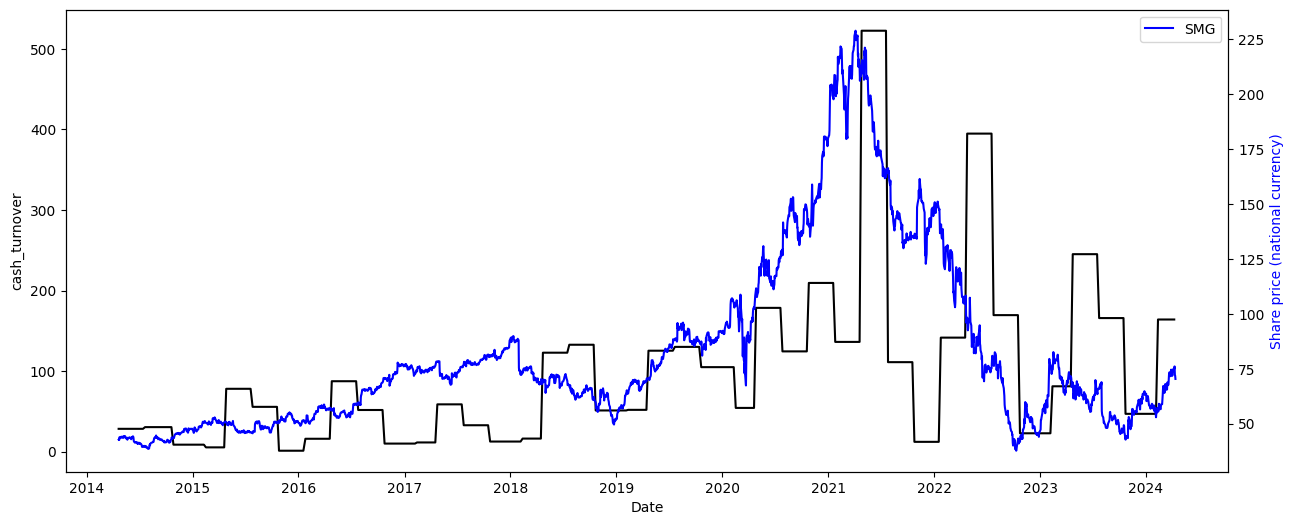

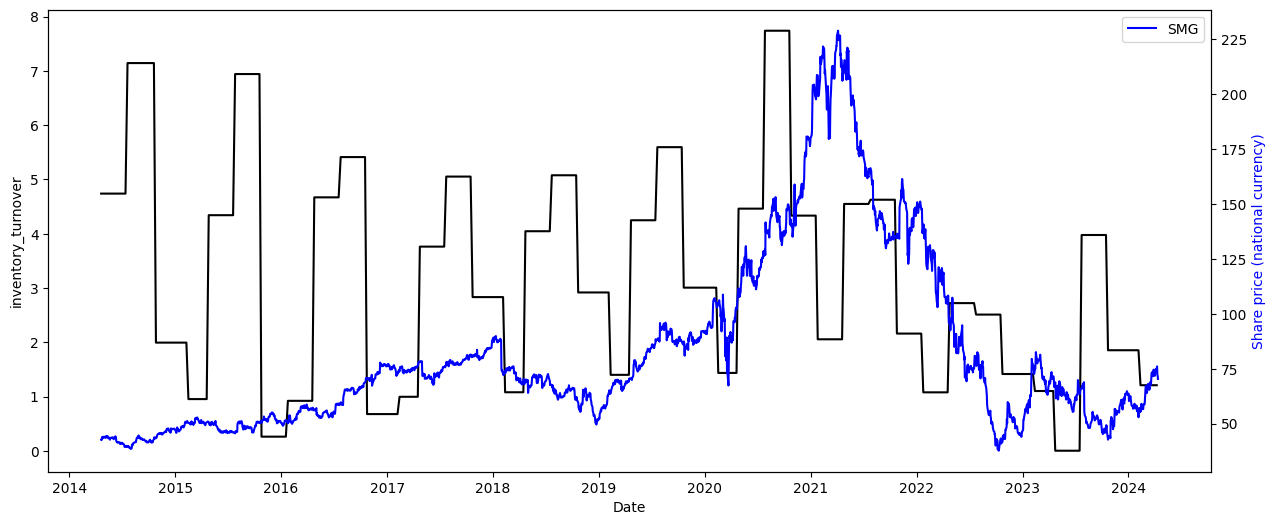

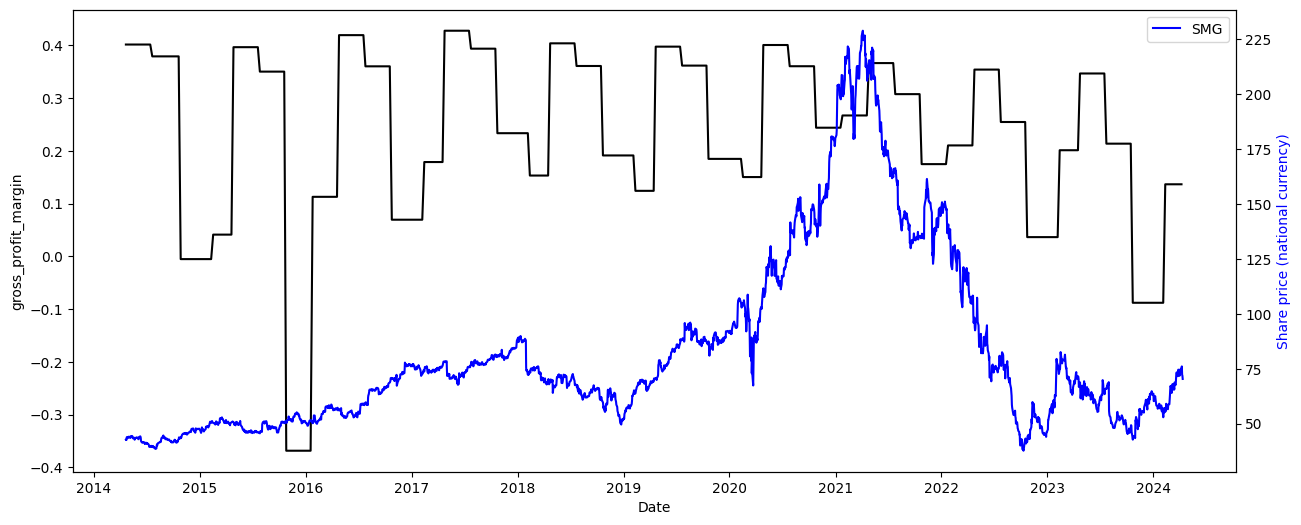

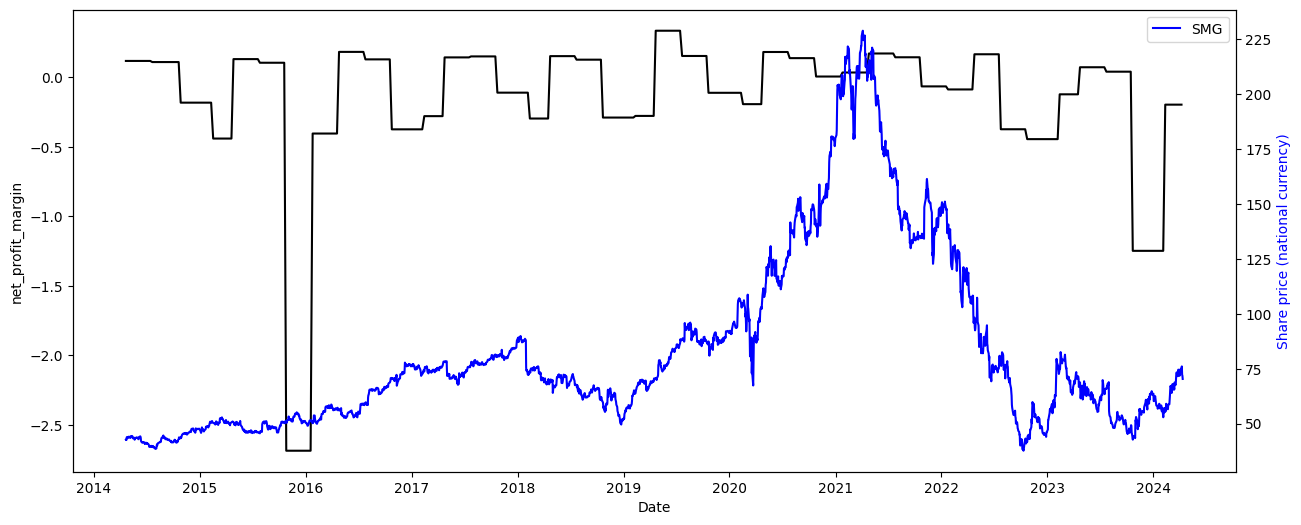

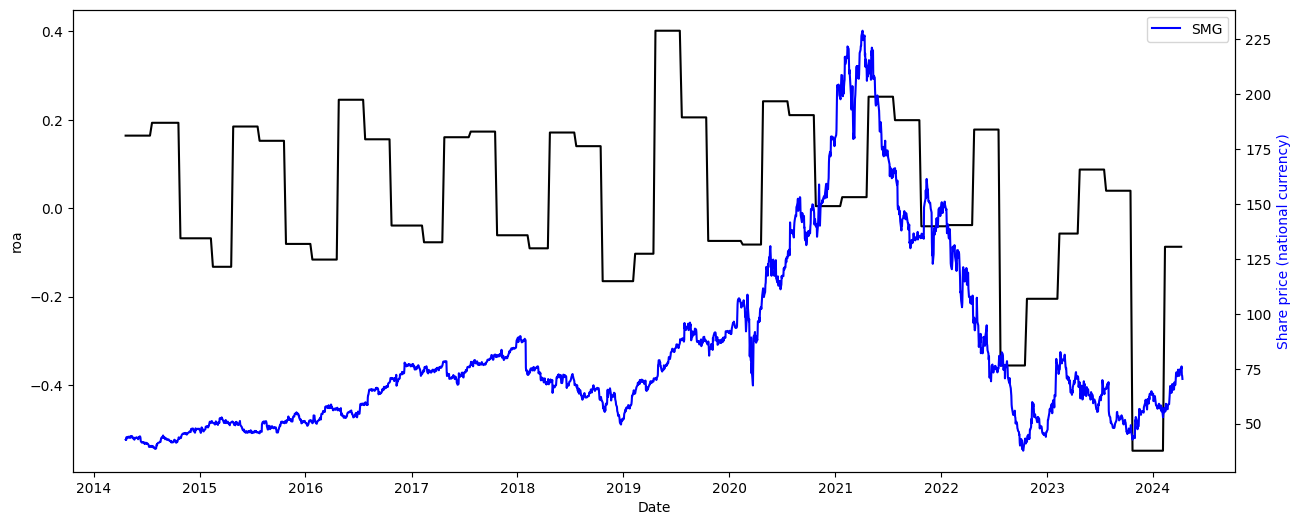

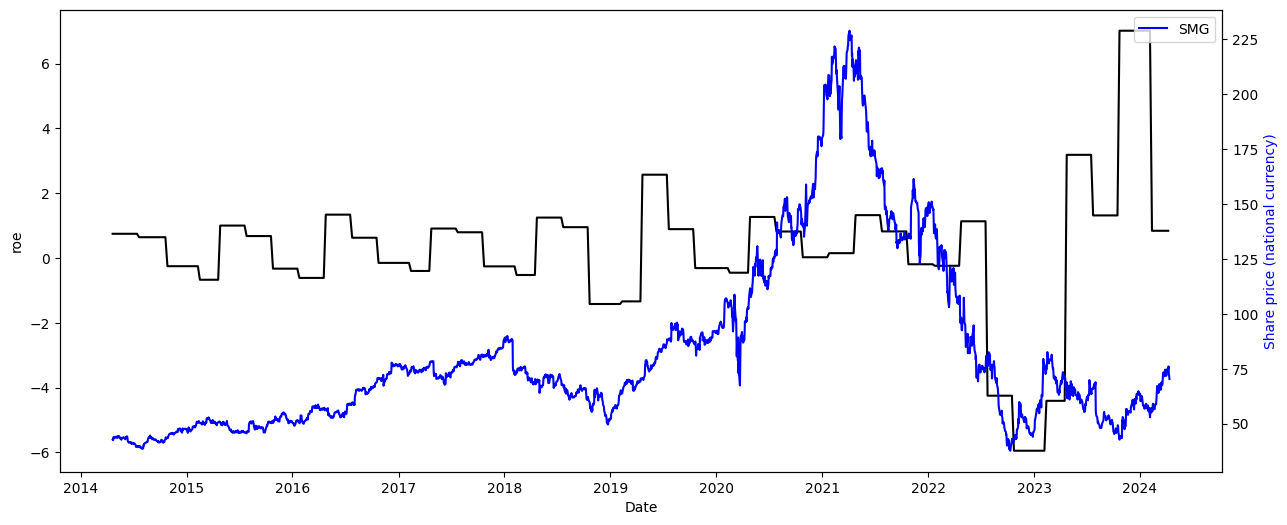

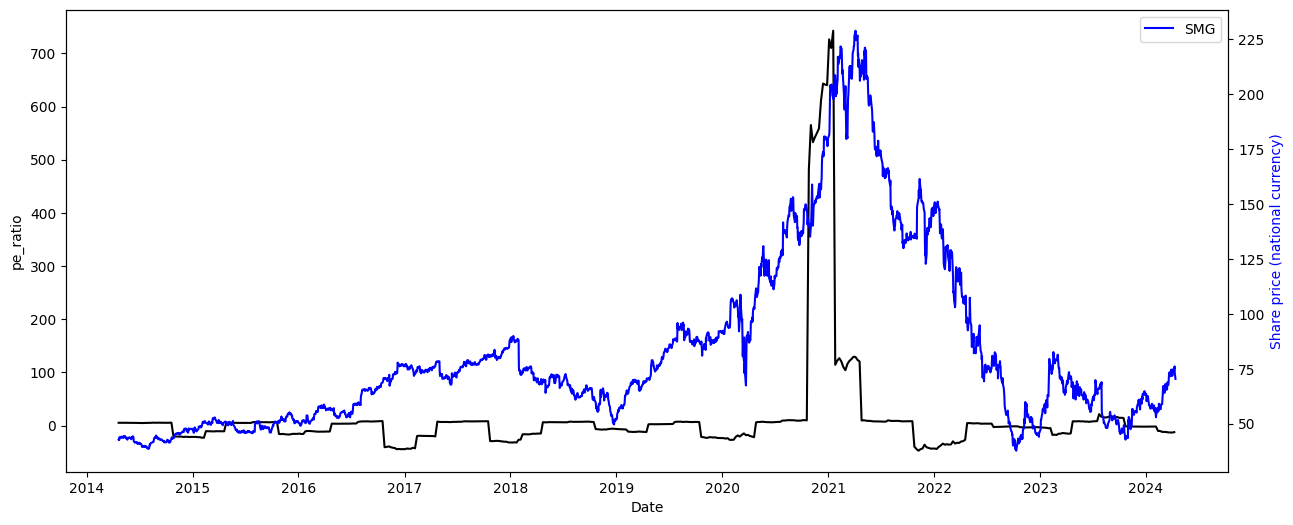

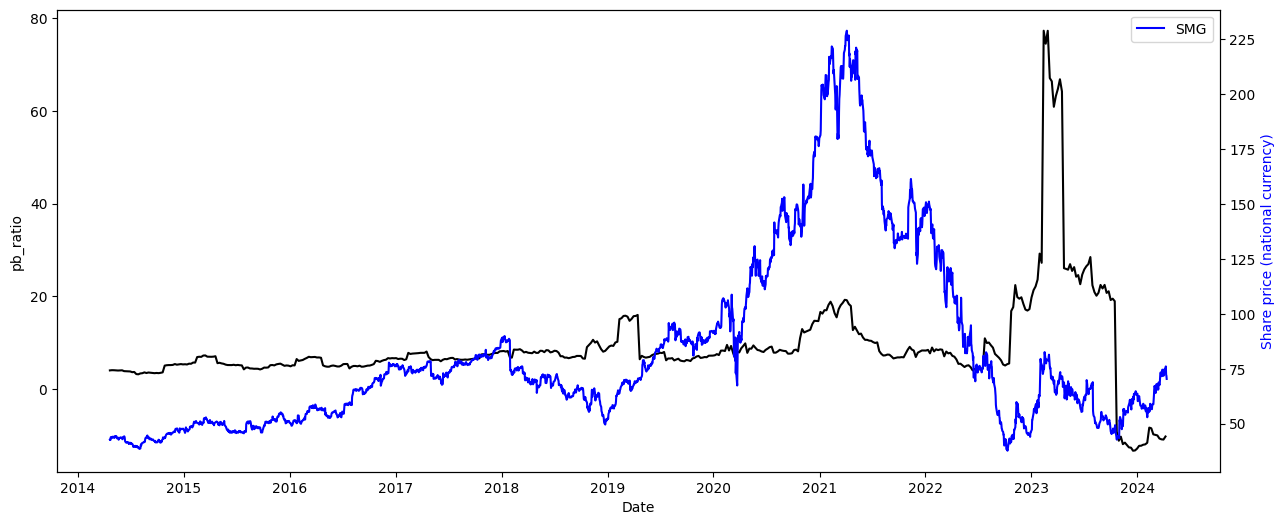

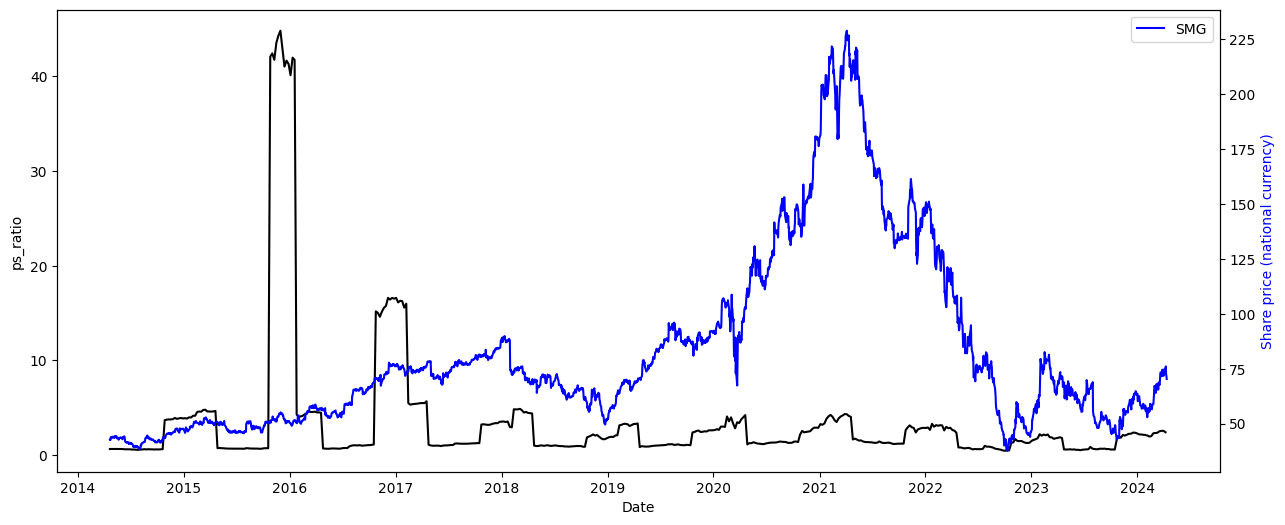

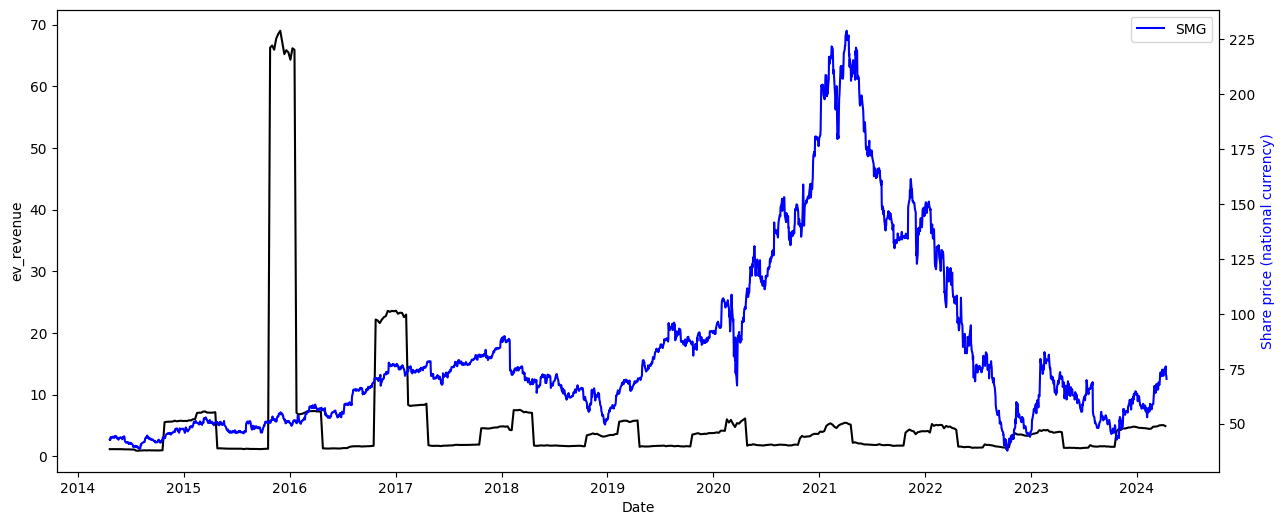

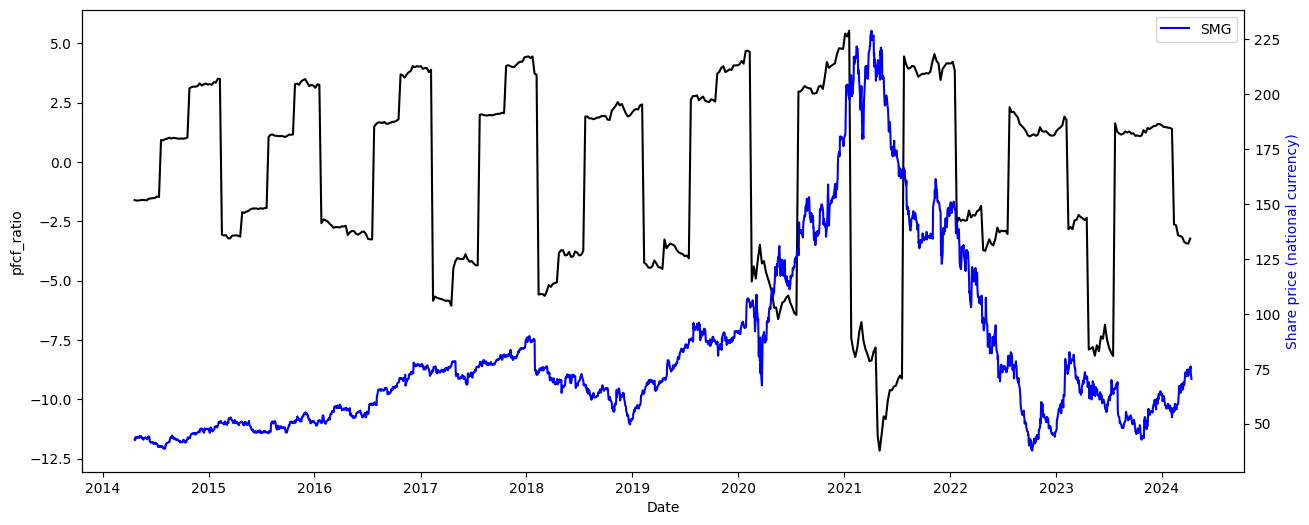

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

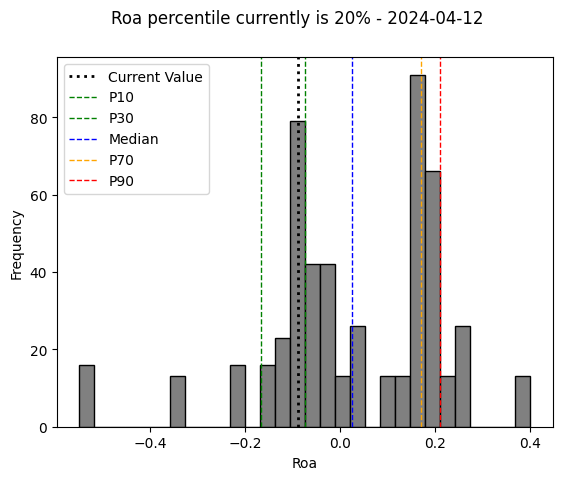

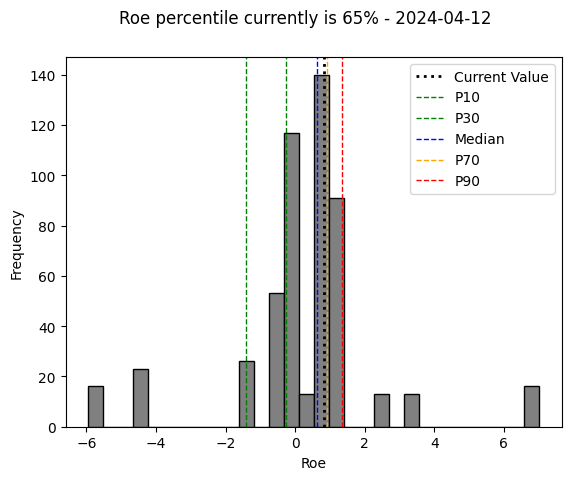

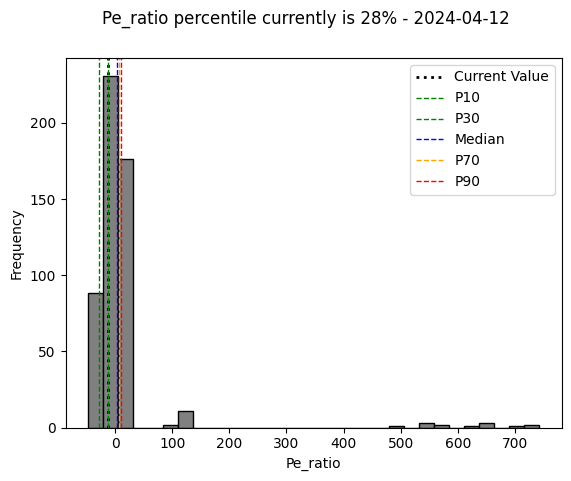

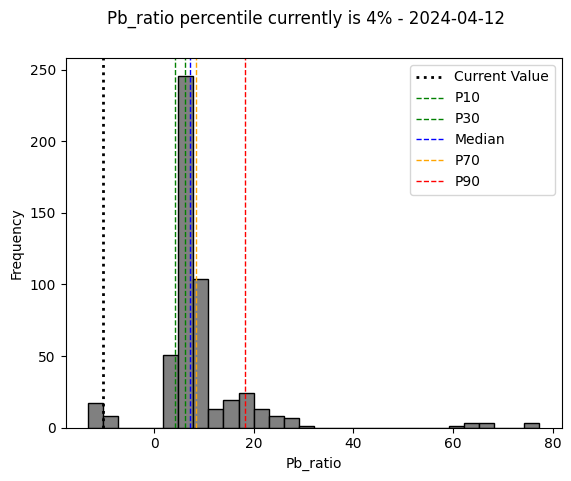

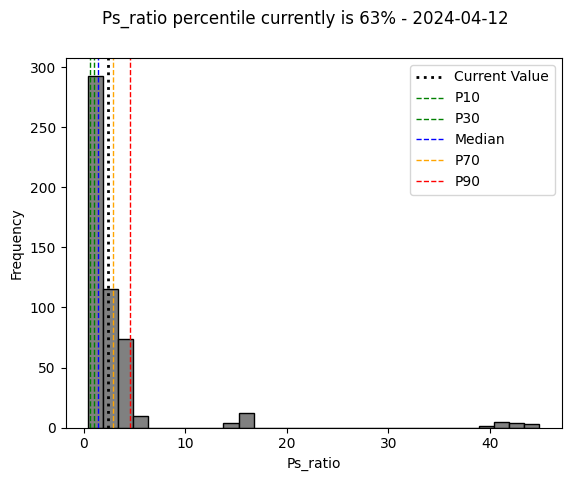

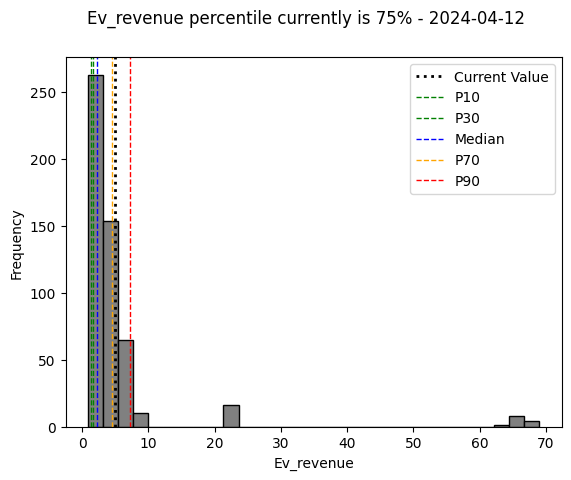

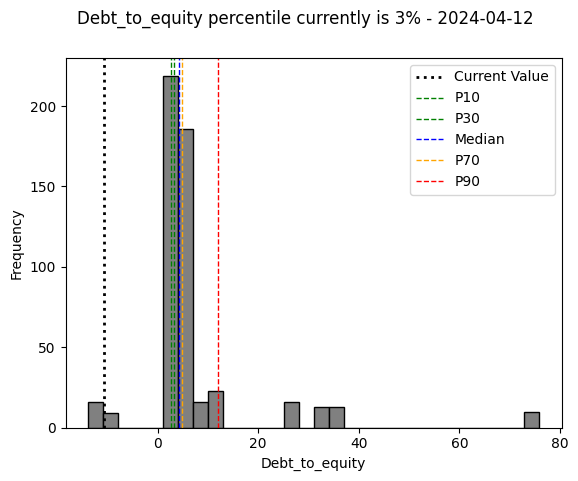

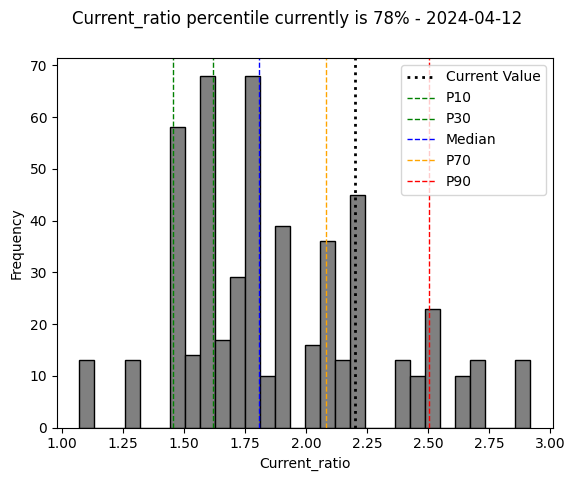

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.206334,0.053204,0.065206,-0.196668,-0.215239,0.010880,-0.183558
roe,0.206334,1.000000,0.027941,-0.496786,-0.090412,-0.092960,-0.472952,-0.204824
pe_ratio,0.053204,0.027941,1.000000,0.100560,-0.068213,-0.082123,-0.034405,-0.267310
pb_ratio,0.065206,-0.496786,0.100560,1.000000,-0.068095,-0.064435,0.942274,0.136081
ps_ratio,-0.196668,-0.090412,-0.068213,-0.068095,1.000000,0.998246,-0.098306,-0.049885
ev_revenue,-0.215239,-0.092960,-0.082123,-0.064435,0.998246,1.000000,-0.082487,-0.030335
debt_to_equity,0.010880,-0.472952,-0.034405,0.942274,-0.098306,-0.082487,1.000000,0.194473
current_ratio,-0.183558,-0.204824,-0.267310,0.136081,-0.049885,-0.030335,0.194473,1.000000


0 timestemos have been found!


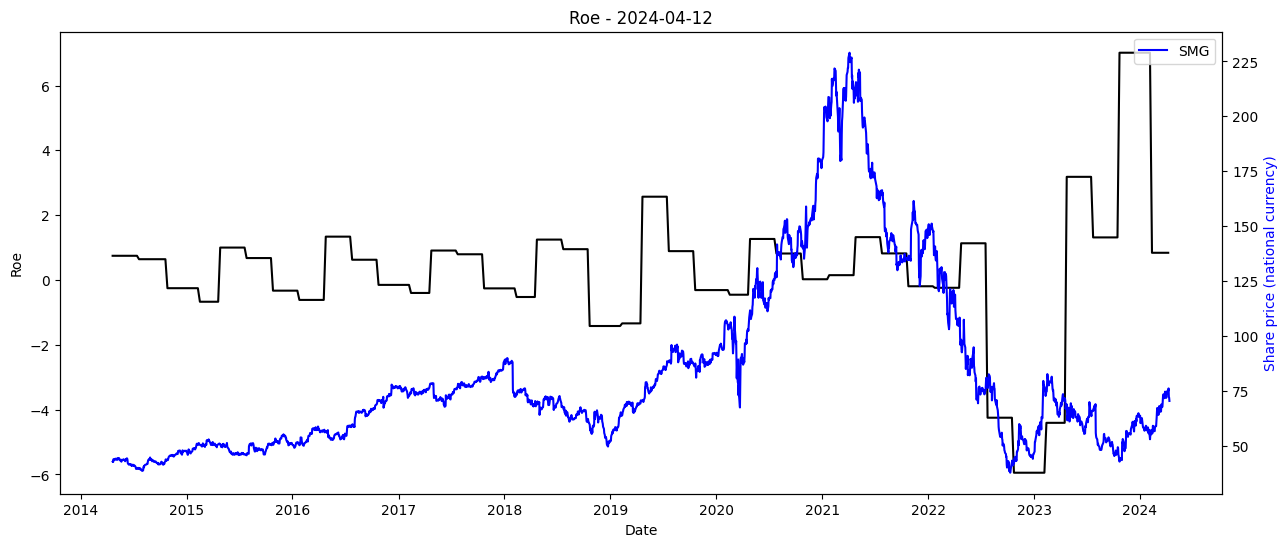

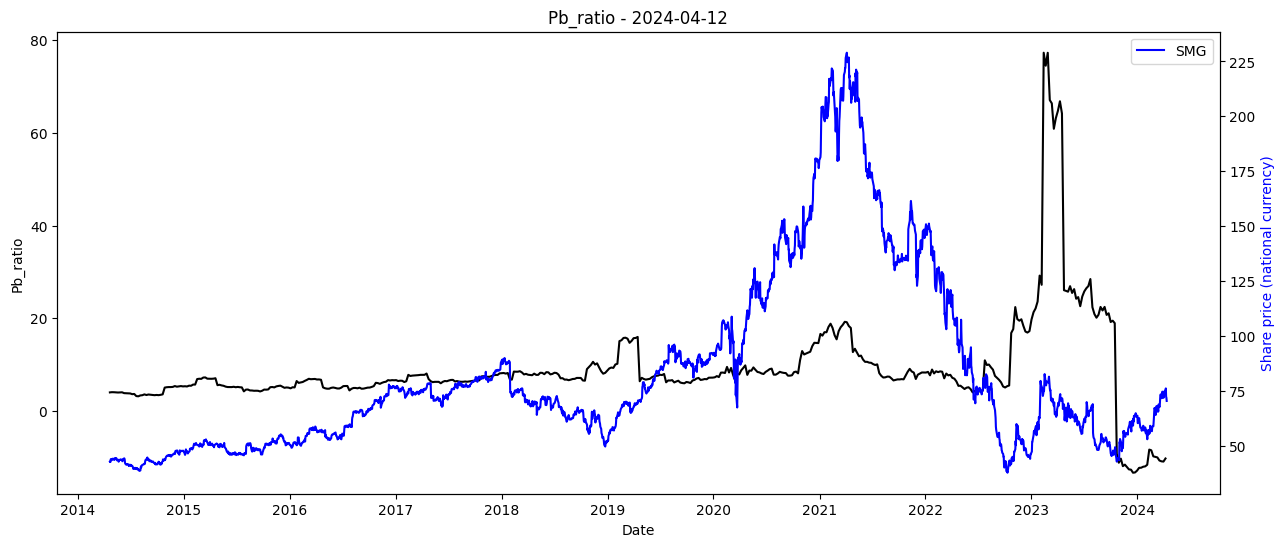

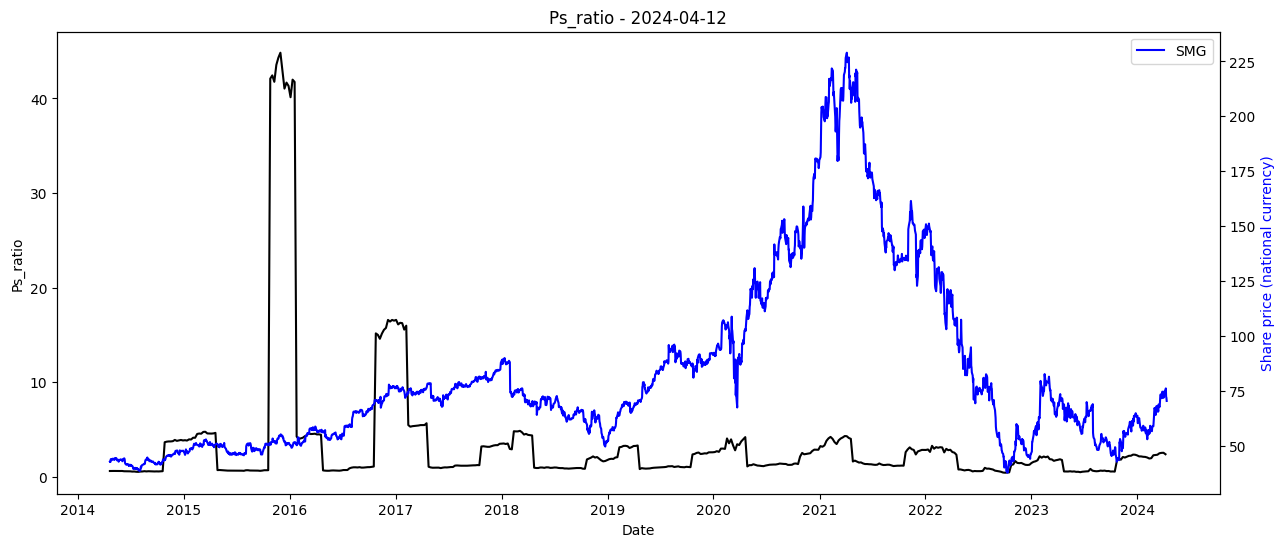

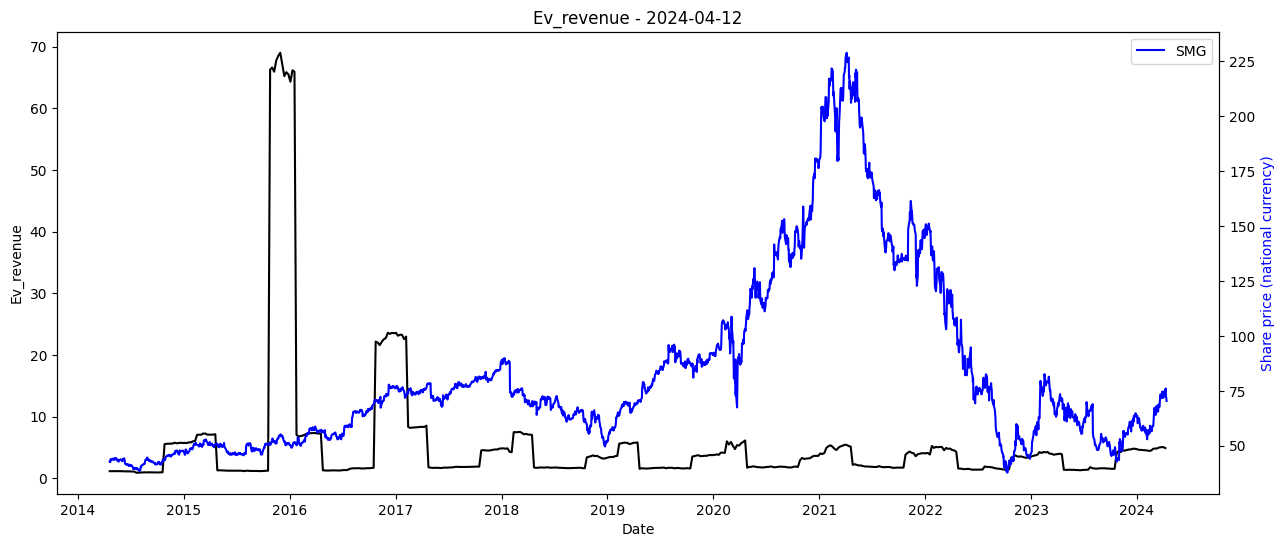

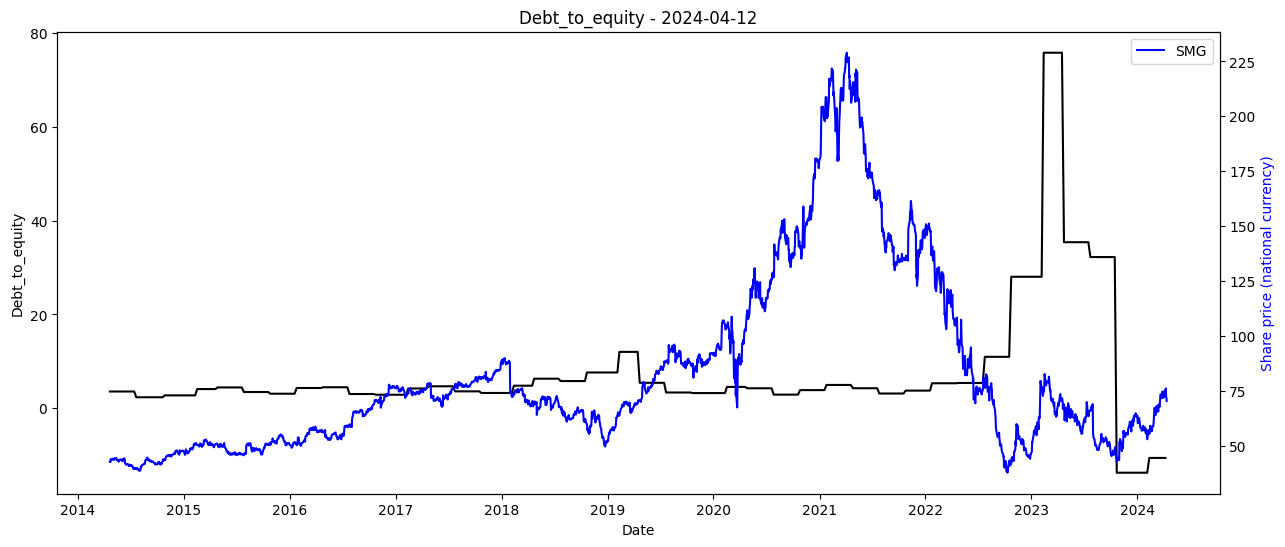

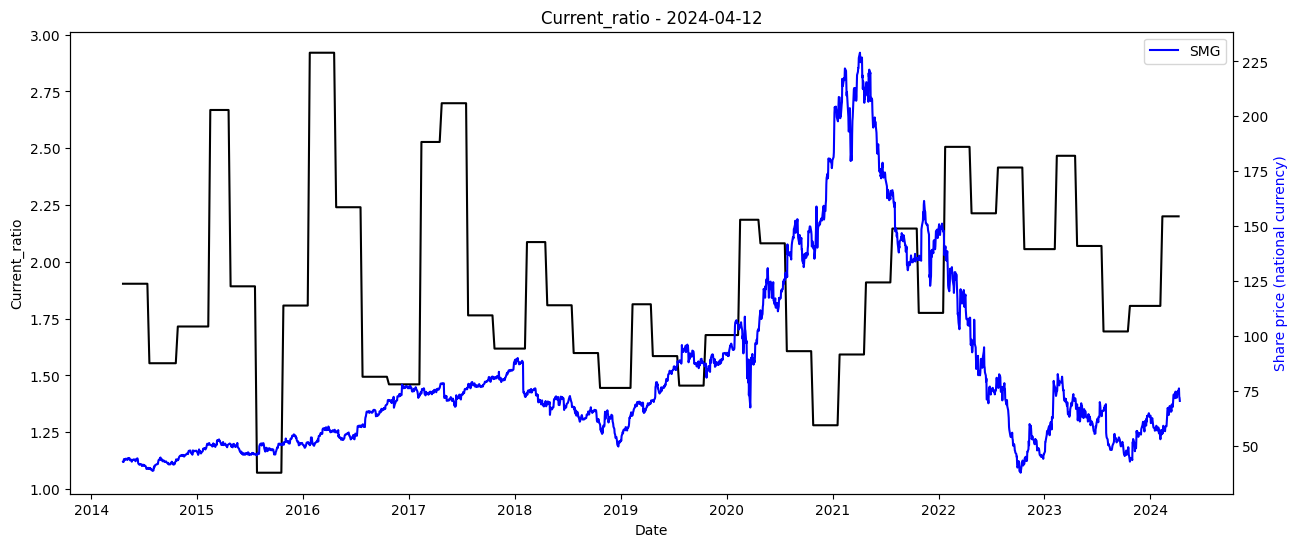

In [21]:
# plot value parameters in time and identify similar events
utils.get_historical_analouges(
    input_df=merged_nat_curr,
    ticker_all_price=ticker_all_price,
    share_name=share_name,
    tolerance=0.2,
    owned_shares=owned_shares
    )